<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization-of-the-notebook" data-toc-modified-id="Initialization-of-the-notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization of the notebook</a></span><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Functions-definitions" data-toc-modified-id="Functions-definitions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions definitions</a></span></li></ul></li><li><span><a href="#Geographic-definition" data-toc-modified-id="Geographic-definition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Geographic definition</a></span></li><li><span><a href="#Foursquare-API" data-toc-modified-id="Foursquare-API-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Foursquare API</a></span><ul class="toc-item"><li><span><a href="#First-round:-look-for-the-restaurants-in-each-CBG" data-toc-modified-id="First-round:-look-for-the-restaurants-in-each-CBG-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>First round: look for the restaurants in each CBG</a></span></li><li><span><a href="#Second-round:-looking-for-venues-around-the-venues" data-toc-modified-id="Second-round:-looking-for-venues-around-the-venues-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Second round: looking for venues around the venues</a></span></li></ul></li><li><span><a href="#Safegraph-visits-pattern" data-toc-modified-id="Safegraph-visits-pattern-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Safegraph visits pattern</a></span></li><li><span><a href="#Final-dataframe" data-toc-modified-id="Final-dataframe-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final dataframe</a></span></li><li><span><a href="#Graphiques" data-toc-modified-id="Graphiques-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Graphiques</a></span></li><li><span><a href="#Machine-Learning-part" data-toc-modified-id="Machine-Learning-part-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Machine Learning part</a></span><ul class="toc-item"><li><span><a href="#SVM" data-toc-modified-id="SVM-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#Random-forest" data-toc-modified-id="Random-forest-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Random forest</a></span></li><li><span><a href="#Logistic" data-toc-modified-id="Logistic-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Logistic</a></span></li></ul></li></ul></div>

# Initialization of the notebook

## Import libraries

In [2]:
%%capture
!pip install tensorflow-tensorboard==0.1.8 ;
!pip install Shapely;
#!pip install folium;

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['ggplot'])

import boto3 #to interact with IBM cloud
import io


from pandas.plotting import scatter_matrix

import ast

import json
from matplotlib import path # for the polygons
import requests
#import pgeocode
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
#import ijson
import json
#import jsonlines
#import Basic

import geopy.distance
from shapely.geometry import Point,Polygon, MultiPolygon
from shapely.ops import cascaded_union

from itertools import islice

#import pysal

import time


## Functions definitions

In [4]:
# The code was removed by Watson Studio for sharing.

I created these 2 functions to upload/download files from the IBM COS.

In [5]:
print('These functions are design to ease files transfert:')
print('upload_ibm(name) and download_ibm(name)')

#my credentials are in the hidden cell

resource = boto3.resource('s3', 
                          aws_access_key_id = credentials["cos_hmac_keys"]['access_key_id'],
                          aws_secret_access_key = credentials["cos_hmac_keys"]["secret_access_key"], 
                          endpoint_url=endpoint, )

#resource.Bucket(name=bucket_name ).put_object(Key=file_name, Body=f.read())

client=boto3.client('s3',
                aws_access_key_id = credentials["cos_hmac_keys"]['access_key_id'],
                aws_secret_access_key = credentials["cos_hmac_keys"]["secret_access_key"], 
                endpoint_url=endpoint)


def upload_ibm(filename):
    with open(filename,'r') as f:
        resource.Bucket(name=bucket_name).put_object(Key=filename,Body=f.read())
    print('File uploaded to COS!')

def download_ibm(filename):
    #if filename[-3:]=='csv':
    file=client.get_object(Bucket=bucket_name,Key=filename)
    data=file['Body'].read()
    return io.BytesIO(data)

These functions are design to ease files transfert:
upload_ibm(name) and download_ibm(name)


# Geographic definition

I use the Census Block Group definition to characterize the locations. First I get the list of the CBG. 

In [6]:
# the file comes from the Safegraph data on Kaggle.
df_geo = pd.read_csv(download_ibm('cbg_geographic_data.csv'))
# change the type of the block name (int -> str )
df_geo['census_block_group']=df_geo['census_block_group'].astype(str)
df_geo.drop(columns='amount_water', inplace=True)
# keep only the census block of Cook County (Chicago)
df_geo=df_geo[df_geo['census_block_group'].str.startswith('17031')]
df_geo.set_index('census_block_group', inplace=True)
# drop the water area CBG
df_geo.drop(df_geo[df_geo.index.str.startswith('170319900')].index,inplace=True)
df_geo.head(1)

,amount_land,latitude,longitude
census_block_group,,,
170310101001,62463.0,42.022054,-87.668363


To get the geographic definition (GPS coordinates) of each block, I used the other Safegraph file 'cbg.geojson'. However, this file is big (3Go) and my laptop could not handle it. The solution I've found is the following: 
* first I read the geojson file line by line, and see if the word "Cook" (for Cook county) is there.

In [ ]:
list_geo=[]
with open(r'C:\Data\safegraph_open_census_data\geometry\cbg.geojson','r') as f:
    for line in f:
        if 'Cook' in line:
            #if any(code in line for code in df_geo.index.values):
            list_geo.append(line)

* Then I kept only the elements I'm interested in: the block id and the coordinates. The coordinate is a polygon characterizes by several points. 

In [ ]:
temp=[]
for item in list_geo:
    b=eval(item)[0]
    temp.append([
            b['properties']['CensusBlockGroup'], 
            b['properties']['State'], 
            b['geometry']['type'],  
            b['geometry']['coordinates'][0][0]])

df_gps=pd.DataFrame(temp,columns=['CensusBlockGroup','state','type','coordinates'])

* Of course, there is a Cook county not only in Illinois, but also in Minnesota, so I selected the state IL.

In [ ]:
# keep only the Cook County in Illinois
df_gps=df_gps[df_gps['state']=='IL']
df_gps.set_index('CensusBlockGroup',inplace=True)

In [ ]:
# merge the 2 dataframe
df_geo=pd.merge(df_geo,df_gps,left_index=True, right_index=True)

Later, for the Foursquare API, I will need a rectangle instead of a polygon. Thus I define the rectangle that encompass all the points inside the polygon. To this end, I use the Shapely library.

In [ ]:
# définie le carré qui entoure chaque bloc
df_geo['carre']=df_geo['coordinates'].apply(lambda x: Polygon(x).bounds)

Here is the file with all the geographic information needed.

In [9]:
df_geo = pd.read_csv(download_ibm('geo.csv'), index_col=0)
df_geo.index = df_geo.index.map(str)
df_geo['carre']=df_geo['carre'].apply(lambda x: ast.literal_eval(x))
df_geo['coordinates']=df_geo['coordinates'].apply(lambda x: ast.literal_eval(x))
df_geo.drop('170318297001',inplace=True)
df_geo.head(2)

,amount_land,latitude,longitude,state,type,coordinates,carre
170310101001,62463.0,42.022054,-87.668363,IL,MultiPolygon,"[[-87.67071800043533, 42.021375999902546], [-8...","(-87.67071999962826, 42.02112199988045, -87.66..."
170310101002,183315.0,42.021357,-87.672752,IL,MultiPolygon,"[[-87.67719899983393, 42.0229420001732], [-87....","(-87.67719899983393, 42.01936399974886, -87.66..."


# Foursquare API

In [10]:
# The code was removed by Watson Studio for sharing.

The first function looks at the venues within a square defined by the south west and north east coordinates. <br>
The second function looks at the venues in the category 'food' within a radius from a given location.

In [11]:
def api_url(SW,NE,CatId,LIMIT=50):
    VERSION = '20180604'
    
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}\
                &categoryId={}&intent={}\
                &sw={}&ne={}\
                &limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            CatId,
            'browse',
            SW,
            NE,
            LIMIT)
    return url

def api_url2(ll,radius,LIMIT=50):
    VERSION = '20180604'
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}\
                &section={}\
                &ll={}\
                &radius={}\
                &limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            'food',
            ll,
            radius,
            LIMIT)
    return url

My focus is on the restaurants. Thus I use the broad category "food".

In [12]:
CatId='4d4b7105d754a06374d81259' #nourriture

One issue with the Foursquare API is that some times it returns no results. In order to keep trying until I get a response, I defined these functions. It keeps trying for 100 times before raising an error.

In [13]:
def get_response(SW,NE,Cat=CatId):
    results=None
    aaa=0
    while results is None:
        try:
            results = requests.get(api_url(SW,NE,Cat)).json()
        except:
            aaa+=1
            if aaa>100:
                print('too many attempt')
                break
    return results

def get_response2(ll,radius):
    results=None
    aaa=0
    while results is None:
        try:
            results = requests.get(api_url2(ll,radius)).json()
        except:
            aaa+=1
            if aaa>100:
                print('too many attempt')
                break
    return results

## First round: look for the restaurants in each CBG

In [ ]:
venues_list=[]
cc=0

lgeo=df_geo['carre'].tolist()
lind=df_geo.index.tolist()

for x,ind in zip(lgeo,lind):
    SW=str(x[1])+','+str(x[0])
    NE=str(x[3])+','+str(x[2])

    results=get_response(SW,NE)

    while (results['meta']['code']>=500) | (results['meta']['code']==403) :
        if results['meta']['code']>=500:
            results=get_response(SW,NE)
            att+=1
            print('tentative de reconnexion n°',att)

        if results['meta']['code']==403:
            time.sleep(60*5)
            results=get_response(SW,NE)
            
    venues_list.append([ind,results])
    
    if len(results['response']['venues'])==50:
        print('CBG n°',ind,'full, divided into 4')
        lgeo.append((x[0],x[1],(x[0]+x[2])/2,(x[1]+x[3])/2))
        lind.append(ind)
        lgeo.append(((x[0]+x[2])/2,(x[1]+x[3])/2,x[2],x[3]))
        lind.append(ind)
        lgeo.append((x[0],(x[1]+x[3])/2,(x[0]+x[2])/2,x[3]))
        lind.append(ind)
        lgeo.append(((x[0]+x[2])/2,x[1],x[2],(x[1]+x[3])/2))
        lind.append(ind)

new_list=[]
for ii in venues_list:
    for a in ii[1]['response']['venues']:
    #a=results['response']['venues'][ii]
        try:
            new_list.append([
                    a['id'], 
                    a['name'], 
                    a['location']['lat'],  
                    a['location']['lng'],
                    a['categories'][0]['id'],
                    a['categories'][0]['name']])
        except:
            print('!! The following POI has a missing information and will be discarded: \n',a)

df1=pd.DataFrame(new_list,columns=['rest_id','rest_name','rest_lat','rest_lon','cat_id','cat_name'])

In [17]:
#remove the duplicate
df1=df1[~df1.duplicated('rest_id',keep='first')]

#sauv
df1.to_csv('step1.csv')
#upload_ibm('step1.csv')
print('step1 completed')

File uploaded to COS!
step1 completed


In [15]:
df1=pd.read_csv(download_ibm('step1.csv'),index_col=1)
df1.head(2)

,Unnamed: 0,rest_name,rest_lat,rest_lon,cat_id,cat_name
rest_id,,,,,,
570ae975498ec708783ef7ab,0,Mexican Vegetarian Cuisine,42.022766,-87.669388,4bf58dd8d48988d1c1941735,Mexican Restaurant
52869069498e3289da674cce,1,Starbucks,42.021330,-87.668147,4bf58dd8d48988d1e0931735,Coffee Shop


Among these 25000 entries, there are restaurants, coffee shop, backeries,...

## Second round: looking for venues around the venues

In [8]:
pt=[]
rad=[]
for x,y in zip(df_geo.latitude,df_geo.longitude):
    pt.append(str(x)+','+str(y))
    
for x in range(len(pt)):
    rad.append(500)
    
venues_list=[]

lgeo=df_geo['carre'].tolist()
lind=df_geo.index.tolist()

for ll,radius in zip(pt,rad):

    results=get_response2(ll,radius)

    while (results['meta']['code']>=500) | (results['meta']['code']==403) :
        if results['meta']['code']>=500:
            results=get_response2(ll,radius)
            att+=1
            print('tentative de reconnexion n°',att)

        if results['meta']['code']==403:
            time.sleep(60*5)
            results=get_response2(ll,radius)
            
    venues_list.append(results['response']['groups'][0]['items'])
    
    if results['response']['totalResults']==50:
        pt.append(ll)
        rad.append(radius*.66)
            
new_list=[]

for x in venues_list:
    for y in x:
        try:
            new_list.append([
                    y['venue']['id'],
                    y['venue']['name'],
                    y['venue']['location']['lat'],
                    y['venue']['location']['lng'],
                    y['venue']['categories'][0]['id'],
                    y['venue']['categories'][0]['name']])
        except:
            print('!! The following POI has a missing information and will be discarded: \n',a)

df2=pd.DataFrame(new_list,columns=['rest_id','rest_name','rest_lat','rest_lon','cat_id','cat_name'])

df2=df2[~df2.duplicated('rest_id',keep='first')]

df2.to_csv('step2.csv')
#upload_ibm('step2.csv')
print('step2 completed')

File uploaded to COS!
step2 completed


In [16]:
df1=pd.read_csv(download_ibm('step1.csv'),index_col=0)
df2=pd.read_csv(download_ibm('step2.csv'),index_col=0)

In [17]:
df3=pd.concat([df1,df2])
df3=df3[~df3.duplicated('rest_id',keep='first')]
df3.to_csv('step3.csv')
#upload_ibm('step3.csv')
print('step3 completed')

step3 completed


In [19]:
df3.head(1)

,rest_id,rest_name,rest_lat,rest_lon,cat_id,cat_name
0,570ae975498ec708783ef7ab,Mexican Vegetarian Cuisine,42.022766,-87.669388,4bf58dd8d48988d1c1941735,Mexican Restaurant


In [18]:
df3.shape

(25602, 6)

And this highlight the issue with the Foursquare: despite asking for all venues in the first round, the second method returns some more entries. <br>
I decided to run a third round, but this one takes time! Indeed, the Foursquare API limits to 5000 calls per hours, so I decided to write some (infinite) loops to ask the servers until the task is complete, waiting 5 minutes between the requests.

In [ ]:
pt=[]
rad=[]
for x,y in zip(df3.rest_lat,df3.rest_lon):
    pt.append(str(x)+','+str(y))
    
for x in range(len(pt)):
    rad.append(500)
    
venues_list=[]

for ll,radius in zip(pt,rad):

    results=get_response2(ll,radius)

    while (results['meta']['code']>=500) | (results['meta']['code']==403) :
        if results['meta']['code']>=500:
            results=get_response2(ll,radius)
            print('erreur serveur')

        if results['meta']['code']==403:
            time.sleep(60*5)
            print('attente de 5min')
            results=get_response2(ll,radius)
            
    venues_list.append(results['response']['groups'][0]['items'])
    
    if results['response']['totalResults']==50:
        pt.append(ll)
        rad.append(radius*.66)
            
new_list=[]

for x in venues_list:
    for y in x:
        try:
            new_list.append([
                    y['venue']['id'],
                    y['venue']['name'],
                    y['venue']['location']['lat'],
                    y['venue']['location']['lng'],
                    y['venue']['categories'][0]['id'],
                    y['venue']['categories'][0]['name']])
        except:
            print('!! The following POI has a missing information and will be discarded: \n',a)

df4=pd.DataFrame(new_list,columns=['rest_id','rest_name','rest_lat','rest_lon','cat_id','cat_name'])

df4=df4[~df4.duplicated('rest_id',keep='first')]

df4.to_csv('step4.csv')
#upload_ibm('step4.csv')
print('step4 completed')

attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
erreur serveur
erreur serveur
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
erreur serveur
erreur serveur
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
erreur serveur
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
attente de 5min
erreur serveur
attente de 5min


In [ ]:
df5=pd.concat([df4,df3])
df5=df5[~df5.duplicated('rest_id',keep='first')]
df5.to_csv('step5.csv')
#upload_ibm('step5.csv')
print('step5 completed')

In [20]:
df5=pd.read_csv(download_ibm('step5.csv'),index_col=0)
df5.head(2)

,rest_id,rest_name,rest_lat,rest_lon,cat_id,cat_name
0,4b5dde6ef964a520fa7029e3,Caribbean American Bakery,42.019371,-87.669705,4bf58dd8d48988d16a941735,Bakery
1,505d49ede4b0236a27575f1b,Sol Café,42.019306,-87.672078,4bf58dd8d48988d16d941735,Café


In [21]:
df5.shape

(26163, 6)

A lot of time for 500 additional entries... It ran at night remotely on the Watson computer. The function upload_ibm() is very convenient to this end.

I'm only interested in the restaurant entries, so I kept only the category ids matching a restaurant category.

In [23]:
# csv with the restaurant categories
df_cat=pd.read_csv(download_ibm('rest_cat.csv'),index_col=0)
df_cat.head(1)

,0
0,52e81612bcbc57f1066b79fb


In [ ]:
rest_cat=df_cat['0'].values
# the function isin() compare each cat_id entry to the list rest_cat
df5=df5[df5.cat_id.isin(rest_cat)]

So now, there are only restaurants in the dataframe. But our method may have include restaurants not in the Cook county.
* Assign each restaurant to a unique CBG:

In [ ]:
df_all=df5

# Add a column with the GPS Point
pp=[]
for lon,lat in zip(df_all['rest_lon'].values,df_all['rest_lat'].values):
    pp.append(Point(lon,lat))
df_all['point']=pp
# find the right CBG for the missing entries. 
# If the point is on the border of several CBG, it is arbitrarily assigned to the first one found.
ll=[]
for ii,x in zip(df_all.rest_id,df_all.point):
    for cbg,pol in zip(df_geo.index,df_geo['coordinates']):
        if Polygon(pol).contains(x):
            ll.append([ii,cbg])
            break
            
ll2=[]
for x in ll:
    if x[1]!='NaN':
        ll2.append(x)
        
dfX=pd.DataFrame(ll2)
dfX.columns=['rest_id','CBG']
dfX.to_csv('stepX.csv')
#upload_ibm('stepX.csv')

In [26]:
dfX=pd.read_csv(download_ibm('stepX.csv'),index_col=0)
dfX.head(2)

,rest_id,CBG
0,5a2071ca47f876422319a3b6,170310101003
1,4b904e30f964a520f18233e3,170310103004


Now we have a complete list of restaurants, where each is assign to a unique CBG. This conclude the Foursquare part.

In [33]:
df=dfX.groupby('CBG').count().reset_index()
df.set_index('CBG',inplace=True)
df.columns=['n_rest']
df_r=df.copy()
df_r.head(1)

,n_rest
CBG,
170310101001,2


# Safegraph visits pattern

If someone wants to use this dataset, I hope the code below will help, especially the lines 9 and the use of json.loads(). 

In [35]:
df_patterns = pd.read_csv(download_ibm('cbg_patterns.csv'))

df_patterns.rename(columns={ df_patterns.columns[0]: "census_block_group" }, inplace=True)
# one entry has no census_block and is not interesting
#df_patterns[df_patterns['census_block_group'].isna()]
df_patterns.dropna(axis=0, inplace=True)

# change the type of census_block and remove the residual decimal from the string
df_patterns['census_block_group']=df_patterns['census_block_group'].astype(str).replace('\.0', '', regex=True)
# keep only the census block of Cook County (Chicago)
df_patterns= df_patterns[df_patterns['census_block_group'].str.startswith('17031')]
df_patterns.set_index('census_block_group', inplace=True)

#split the popularity by hours into columns
# labels of new columns '0h','1h'...
hours=[]
for x in range(24):
    hours.append(str(x)+'h')
df_patterns[hours] = pd.DataFrame(df_patterns['popularity_by_hour']
                                  .map(lambda x: np.array(json.loads(x))) #json.loads > ast.literal_eval
                                  .tolist(), index= df_patterns.index)

df_patterns.drop(columns=['popularity_by_hour',
                          'date_range_start','date_range_end',
                          'related_same_day_brand','related_same_month_brand','top_brands',
                          'visitor_home_cbgs','visitor_work_cbgs','distance_from_home'
                         ],inplace=True)

# split the popularity by day into columns
df_patterns['popularity_by_day'] = df_patterns.popularity_by_day.map(lambda x:json.loads(x))
df_patterns=df_patterns.join(pd.DataFrame.from_dict(df_patterns['popularity_by_day'].to_dict(),orient='index'),how="inner")
df_patterns.drop(columns=['popularity_by_day'],inplace=True)

temp=df_patterns.loc[['170318297001','170318297002']].sum()
df_patterns.loc['170318297002']=temp
df_patterns.drop('170318297001',inplace=True)

df_patterns.head(2)

,raw_visit_count,raw_visitor_count,0h,1h,2h,3h,4h,5h,6h,7h,8h,9h,10h,11h,12h,13h,14h,15h,16h,17h,18h,19h,20h,21h,22h,23h,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
170310702002,36224.0,12468.0,1610.0,1475.0,1323.0,1170.0,1131.0,1234.0,1780.0,3046.0,2731.0,2452.0,2352.0,2446.0,2477.0,2477.0,2644.0,2670.0,2714.0,2850.0,2908.0,2679.0,2478.0,2394.0,2103.0,1903.0,5244.0,5175.0,5410.0,4550.0,5417.0,5723.0,4705.0
170311605023,31322.0,11029.0,1546.0,1349.0,1277.0,1211.0,1267.0,1392.0,1860.0,2766.0,2340.0,1832.0,1780.0,1819.0,1941.0,1879.0,2203.0,3033.0,2861.0,2872.0,2726.0,2472.0,2015.0,1880.0,1871.0,1624.0,5082.0,5051.0,4897.0,3963.0,4279.0,4108.0,3942.0


# Final dataframe

I also includes some Census data information:
* population size
* median Age
* income distribution
* employed population: number of workers (Tot_occ), in which sector (HD_)

In [45]:
df=pd.read_csv(download_ibm('df_all.csv'),index_col=0)
df['inc_mid']=df.inc_q2+df.inc_q3
df['p_rest']=df.n_rest.div(df.population)
df['p_occ']=df.Tot_occ.div(df.population)
df['p_visitor']=df.raw_visitor_count.div(df.population)
df['p_visit']=df.raw_visit_count.div(df.population)
df.index = df.index.map(str)
df=pd.merge(df,df_geo,how='left',right_index=True,left_index=True)
df.head(1)

,population,Age_Median,inc_q1,inc_q2,inc_q3,inc_q4,Tot_occ,HD01_VD03,HD01_VD19,HD01_VD27,HD01_VD30,HD01_VD34,HD01_VD39,HD01_VD55,HD01_VD63,HD01_VD66,HD01_VD70,amount_land_x,latitude_x,longitude_x,raw_visit_count,raw_visitor_count,0h,1h,2h,3h,4h,5h,6h,7h,8h,9h,10h,11h,12h,13h,14h,15h,16h,17h,18h,19h,20h,21h,22h,23h,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,jap,afrique,asie,latin,us,europe,oceanie,indian,n_rest,inc_mid,p_rest,p_occ,p_visitor,p_visit,amount_land_y,latitude_y,longitude_y,state,type,coordinates,carre
170310101001,579,38.9,0.56338,0.0,0.359155,0.077465,341,0.246334,0.043988,0.187683,0.0,0.061584,0.214076,0.158358,0.041056,0.0,0.046921,62463.0,42.022054,-87.668363,11523,3845,776,757,732,715,682,695,917,1039,1048,917,825,825,797,819,843,917,1037,1115,1044,1000,905,919,858,823,1804,1847,1671,1453,1607,1661,1480,0,0,0,1,1,0,0,0,2,0.359155,0.003454,0.588946,6.64076,19.901554,62463.0,42.022054,-87.668363,IL,MultiPolygon,"[[-87.67071800043533, 42.021375999902546], [-8...","(-87.67071999962826, 42.02112199988045, -87.66..."


The number of restaurants among the CBG is the following:

In [38]:
df[['n_rest']].describe().T

,count,mean,std,min,25%,50%,75%,max
n_rest,3991.0,2.934603,5.165238,0.0,0.0,2.0,4.0,156.0


# Graphiques 

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['ggplot'])
import seaborn as sns

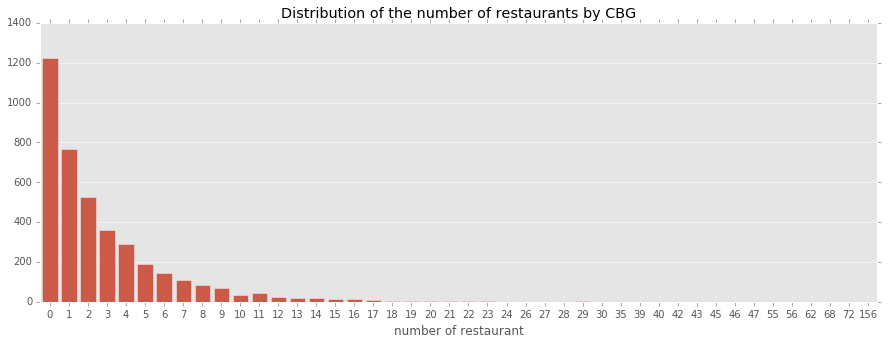

In [54]:
plt.figure(figsize=(15,5))
sns.countplot(x="n_rest",data=df, color='C0')
plt.xlabel('number of restaurant')
plt.ylabel('')
plt.title('Distribution of the number of restaurants by CBG')
plt.show()

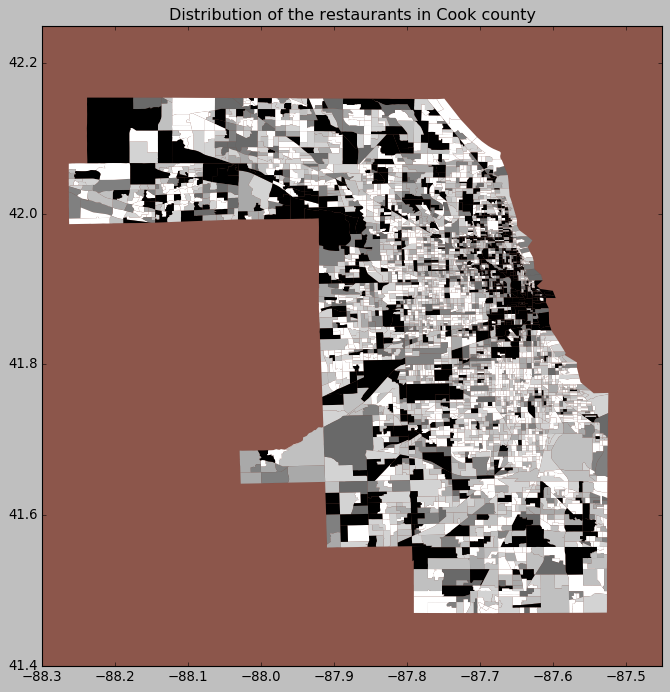

In [50]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib as mpl

plt.style.use(['classic'])

fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor('tab:brown')

patches = []
for a,n in zip(df.coordinates,df.n_rest):
    if n==0:
        p = Polygon(np.array(a),fc='white',ec='k',zorder=2, lw=.01)
        patches.append(p)
    if n==1:
        p = Polygon(np.array(a),fc='lightgray',ec='k',zorder=2, lw=.01)
        patches.append(p) 
    if n==2:
        p = Polygon(np.array(a),fc='silver',ec='k',zorder=2, lw=.01)
        patches.append(p)
    if n==3:
        p = Polygon(np.array(a),fc='darkgrey',ec='k',zorder=2, lw=.01)
        patches.append(p)
    if n==4:
        p = Polygon(np.array(a),fc='gray',ec='k',zorder=2, lw=.01)
        patches.append(p)
    if n==5:
        p = Polygon(np.array(a),fc='dimgrey',ec='k',zorder=2, lw=.01)
        patches.append(p)
    if n>5:
        p = Polygon(np.array(a),fc='black',ec='k',zorder=2, lw=.01)
        patches.append(p)

ax.add_collection(PatchCollection(patches,match_original=True))
xrange = [-88.3, -87.45]
ax.set_xlim(xrange)
yrange = [41.4, 42.25]
ax.set_ylim(yrange)
ax.set_title('Distribution of the restaurants in Cook county')
fig.show()

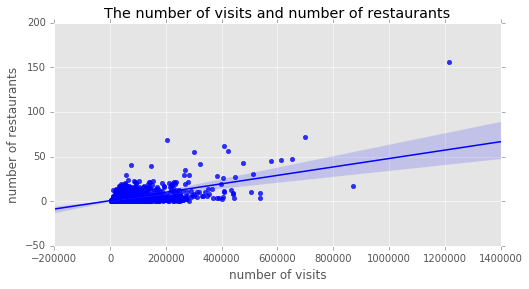

In [67]:
fig, ax = plt.subplots(figsize=(8,4))
sns.regplot(y="n_rest",x="raw_visit_count",data=df[df.n_rest>-1],logx=False,color='b')
plt.ylabel('number of restaurants')
plt.xlabel('number of visits')
plt.title('The number of visits and number of restaurants')
plt.show()

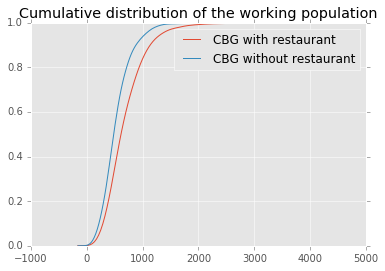

In [65]:
sns.kdeplot(df[df.n_rest>0].Tot_occ,  cumulative=True,label="CBG with restaurant")
sns.kdeplot(df[df.n_rest==0].Tot_occ, cumulative=True,label="CBG without restaurant")
plt.title("Cumulative distribution of the working population")
plt.legend();

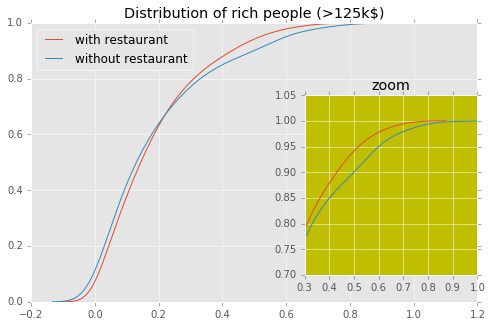

In [62]:
fig, ax = plt.subplots(figsize=(8,5))
sns.kdeplot(df[df.n_rest>0].inc_q4,  cumulative=True,label="with restaurant",ax=ax)
sns.kdeplot(df[df.n_rest==0].inc_q4, cumulative=True,label="without restaurant",ax=ax)
ax.set_title('Distribution of rich people (>125k$)')
plt.legend(loc='upper left')



ax2 = plt.axes([0.6, 0.2, .3, .5], facecolor='y')
sns.kdeplot(df[df.n_rest>0].inc_q4,  cumulative=True,label="with restaurant",ax=ax2,legend=False)
sns.kdeplot(df[df.n_rest==0].inc_q4, cumulative=True,label="without restaurant",ax=ax2,legend=False)
ax2.set_title('zoom')
ax2.set_xlim([0.3,1.])
ax2.set_ylim([0.7,1.051])


plt.show()

# Machine Learning part

The feature analysis is done with Stata as explained in the repport. Briefly, PCA and FA may lead to similar results but in my case, factor analysis is prefered. Since I like Stata, I did this part using it.

In [ ]:
import ipystata

In [ ]:
%%stata  -d df -o df2
gen inc_med=inc_q1+inc_q2
gen p = 0

factor ///
_0h _1h _2h _3h _4h _5h _6h _7h _8h _9h _10h _11h _12h _13h _14h _15h _16h _17h _18h _19h _20h _21h _22h _23h ///
Monday Tuesday Wednesday Thursday Friday Saturday Sunday, pcf mineigen(.1)

rotate

predict X1 X2 X3 X4 X5

In [69]:
df=pd.read_csv(download_ibm('all_with_stata.csv'),index_col=0)
df.head(1)

,population,Age_Median,inc_q1,inc_q2,inc_q3,inc_q4,Tot_occ,HD01_VD03,HD01_VD19,HD01_VD27,HD01_VD30,HD01_VD34,HD01_VD39,HD01_VD55,HD01_VD63,HD01_VD66,HD01_VD70,amount_land,latitude,longitude,raw_visit_count,raw_visitor_count,_0h,_1h,_2h,_3h,_4h,_5h,_6h,_7h,_8h,_9h,_10h,_11h,_12h,_13h,_14h,_15h,_16h,_17h,_18h,_19h,_20h,_21h,_22h,_23h,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,jap,afrique,asie,latin,us,europe,oceanie,indian,n_rest,inc_mid,p_rest,p_occ,p_visitor,p_visit,inc_med,p,X1,X2,X3,X4,X5
0,579,38.9,0.56338,0.0,0.359155,0.077465,341,0.246334,0.043988,0.187683,0.0,0.061584,0.214076,0.158358,0.041056,0.0,0.046921,62463.0,42.022054,-87.668363,11523,3845,776,757,732,715,682,695,917,1039,1048,917,825,825,797,819,843,917,1037,1115,1044,1000,905,919,858,823,1804,1847,1671,1453,1607,1661,1480,0,0,0,1,1,0,0,0,2,0.359155,0.003454,0.588946,6.64076,19.901554,0.56338,0.0,-0.458035,-0.577387,-0.078884,-0.008776,-0.14708


The 5 new variables X1~X5 are the factors capturing most of the common features from the visit pattern (0h~23h and Monday~Saturday).

The features used are the following:

In [71]:
colX=['population', #population size
      'Age_Median', # median age
      'inc_q2', 'inc_q3', 'inc_q4', #income distribution
      'Tot_occ', #number of workers 
      'HD01_VD03', 'HD01_VD19', 'HD01_VD27', 'HD01_VD30',
       'HD01_VD34', 'HD01_VD39', 'HD01_VD55', 'HD01_VD63', 'HD01_VD66',
       'HD01_VD70', #working sector 
      'amount_land', #surface area
      'X1','X2', 'X3', 'X4', 'X5'] #factors explaining the visit patterns

In [72]:
from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

In [73]:
def nice_hist(values_A,values_B,model=''):


    bins = np.arange(0,5,1)

    fig, ax = plt.subplots(figsize=(9, 5))
    _, bins, patches = plt.hist([np.clip(values_A, bins[0], bins[-1]),
                                 np.clip(values_B, bins[0], bins[-1])],
                                # normed=1,  # normed is deprecated; replace with density
                                density=False, stacked=True, edgecolor='white', width=.7,
                                bins=bins, color=['#3782CC', 'red'], label=['True', 'False'])

    xlabels = bins[:-1].astype(str)
    xlabels[-1] += '+'

    N_labels = len(xlabels)
    plt.xlim([0, 4])
    plt.xticks(1* np.arange(N_labels) + 0.35)
    ax.set_xticklabels(xlabels)

    #plt.yticks([])
    plt.title('Frequency of the predictions ('+model+')')
    plt.xlabel('Actual number of restaurants in the CBG')
    plt.setp(patches, linewidth=0)
    plt.legend(loc='upper left')
#     plt.legend(loc='upper center')

    fig.tight_layout()

## SVM 

The confusion matrix:
[[ 108  382]
 [  65 1042]]
precision: 0.7317415730337079
recall: 0.941282746160795
For the CBG with more than 3 restaurants:
TP = 577
FN = 15
Recall score (n>=3) 0.9746621621621622


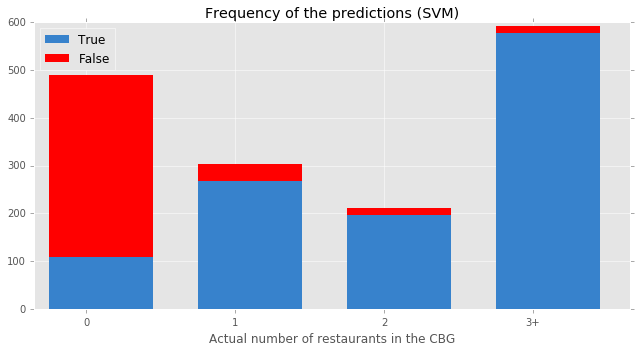

In [75]:
cat='n_rest'
X=df[colX].values

y=df[cat].values>0 
y=y+1-1

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4,random_state=5)
sss.get_n_splits(X, y)

a=1
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    # eventually, use preprocessing.RobustScaler() to remove outliers
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    svc = SVC(C=1,kernel='rbf',gamma=.07)
    svc.fit(X_train_s,y_train)
    y_pred = svc.predict(X_test_s)
    y_obs = y[test_index]

    cm = confusion_matrix(y_obs.tolist(), y_pred.tolist())
    print('The confusion matrix:')
    print(cm)
    
    df_test=df.iloc[test_index].copy()
    df_test['y_pred']=y_pred
    df_test['y']=(df_test[cat].values>0)+1-1 

    

    values_A = df_test[df_test.y_pred==df_test.y][cat]
    values_B = df_test[df_test.y_pred!=df_test.y][cat]

    nice_hist(values_A,values_B,"SVM")
    
    precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred,average='binary')
    

#     print('split number',a)
    a=a+1
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
#     print('fscore: {}'.format(fscore))

    print("For the CBG with more than 3 restaurants:")
    print('TP =',df_test[(df_test.y_pred==1) & (df_test.n_rest>=3)].shape[0])
    print('FN =',df_test[(df_test.y_pred==0) & (df_test.n_rest>=3)].shape[0])
    print('Recall score (n>=3)',
         (df_test[(df_test.y_pred==1) & (df_test.n_rest>=3)].shape[0])/(df_test[(df_test.n_rest>=3)].shape[0]))

## Random forest

[[183 307]
 [128 979]]
precision: 0.7612752721617418
recall: 0.8843721770551038
For the CBG with more than 3 restaurants:
TP = 564
FN = 28
Recall score (n>=3) 0.9527027027027027


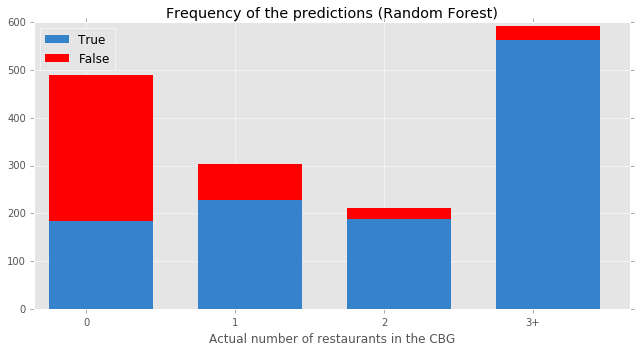

In [77]:
cat='n_rest'
X=df[colX].values

y=df[cat].values>0 
y=y+1-1

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4,random_state=5)
sss.get_n_splits(X, y)

a=1
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    # eventually, use preprocessing.RobustScaler() to remove outliers
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    rfc = RandomForestClassifier(n_estimators=30,criterion='entropy',class_weight='balanced')
    rfc.fit(X_train_s,y_train)
    # predictions
    y_pred = rfc.predict(X_test_s)
    y_obs = y[test_index]

    cm = confusion_matrix(y_obs, y_pred)
    print(cm)
    
    df_test=df.iloc[test_index].copy()
    df_test['y_pred']=y_pred
    df_test['y']=(df_test[cat].values>0)+1-1 

    

    values_A = df_test[df_test.y_pred==df_test.y][cat]
    values_B = df_test[df_test.y_pred!=df_test.y][cat]

    nice_hist(values_A,values_B,'Random Forest')
    
    precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred,average='binary')
    

 #   print('split number',a)
    a=a+1
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
#    print('fscore: {}'.format(fscore))
#     print('support: {}'.format(support))

print("For the CBG with more than 3 restaurants:")
print('TP =',df_test[(df_test.y_pred==1) & (df_test.n_rest>=3)].shape[0])
print('FN =',df_test[(df_test.y_pred==0) & (df_test.n_rest>=3)].shape[0])
print('Recall score (n>=3)',
     (df_test[(df_test.y_pred==1) & (df_test.n_rest>=3)].shape[0])/(df_test[(df_test.n_rest>=3)].shape[0]))

## Logistic

[[379 111]
 [397 710]]
precision: 0.8647990255785627
recall: 0.6413730803974707
For the CBG with more than 3 restaurants:
TP = 468
FN = 124
Recall score (n>=3) 0.7905405405405406


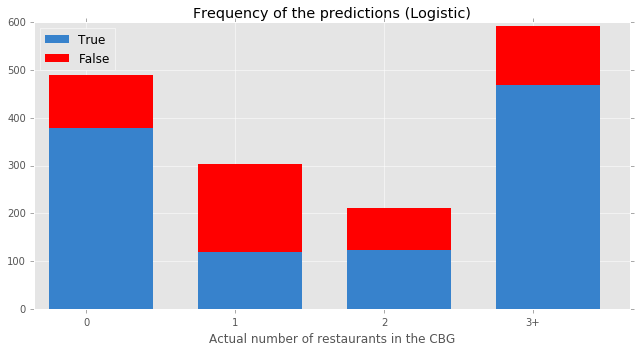

In [78]:
cat='n_rest'
X=df[colX].values

y=df[cat].values>0 
y=y+1-1

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4,random_state=5)
sss.get_n_splits(X, y)

a=1
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    # eventually, use preprocessing.RobustScaler() to remove outliers
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    logreg = LogisticRegression(solver='lbfgs',C=100,random_state=5,class_weight='balanced')
    logreg.fit(X_train_s, y_train)
    y_pred = logreg.predict(X_test_s)
    y_obs = y[test_index]

    cm = confusion_matrix(y_obs, y_pred)
    print(cm)
    
        
    df_test=df.iloc[test_index].copy()
    df_test['y_pred']=y_pred
    df_test['y']=(df_test[cat].values>0)+1-1 

    

    values_A = df_test[df_test.y_pred==df_test.y][cat]
    values_B = df_test[df_test.y_pred!=df_test.y][cat]

    nice_hist(values_A,values_B,'Logistic')
    
    precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred,average='binary',pos_label=1)
    

#     print('split number',a)
    a=a+1
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
#     print('fscore: {}'.format(fscore))
#     print('support: {}'.format(support))


print("For the CBG with more than 3 restaurants:")
print('TP =',df_test[(df_test.y_pred==1) & (df_test.n_rest>=3)].shape[0])
print('FN =',df_test[(df_test.y_pred==0) & (df_test.n_rest>=3)].shape[0])
print('Recall score (n>=3)',
     (df_test[(df_test.y_pred==1) & (df_test.n_rest>=3)].shape[0])/(df_test[(df_test.n_rest>=3)].shape[0]))

In [81]:
df[df.n_rest==0].shape

(1224, 74)